In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import sympy as sp
from sympy import *
import math
import re



with open("equation.txt") as f:
    for line in f:
        e = line #e is the equation

#pe is the proper equation format in np
pe = e

functions = ['sin', 'cos', 'tan', 'exp', 'log', 'sqrt']

for f in functions:
    pe = re.sub(rf'\b{f}\b', f'np.{f}', pe)
pe = pe.replace('^', '**')
pe = re.sub(r'\be\b', 'np.e', pe)


se = pe.replace('np.', '')

print(e)
print(pe)
print(se)

def make_function(ex): #pe
    allowed_names = {
        'np': np,
        'x': None  # placeholder, replaced at call time
    }

    def f(x):
        local_dict = allowed_names.copy()
        local_dict['x'] = x
        return eval(ex, {"__builtins__": {}}, local_dict)

    return f



cos(x)
np.cos(x)
cos(x)


In [34]:
x = sp.symbols('x')
f = sp.sympify(se)

def findTaylor(times):
    taylors = f.subs(x,0)
    diffed = f
    for i in range(1, times):
        diffed = diffed.diff(x)
        taylors += diffed.subs(x,0) * 1/(factorial(i))*(x**i)
    return taylors

print(findTaylor(25))

x**24/620448401733239439360000 - x**22/1124000727777607680000 + x**20/2432902008176640000 - x**18/6402373705728000 + x**16/20922789888000 - x**14/87178291200 + x**12/479001600 - x**10/3628800 + x**8/40320 - x**6/720 + x**4/24 - x**2/2 + 1


/var/folders/zs/4103krws4jxgvc42d5j93xdc0000gn/T/ipykernel_13897/2948040823.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


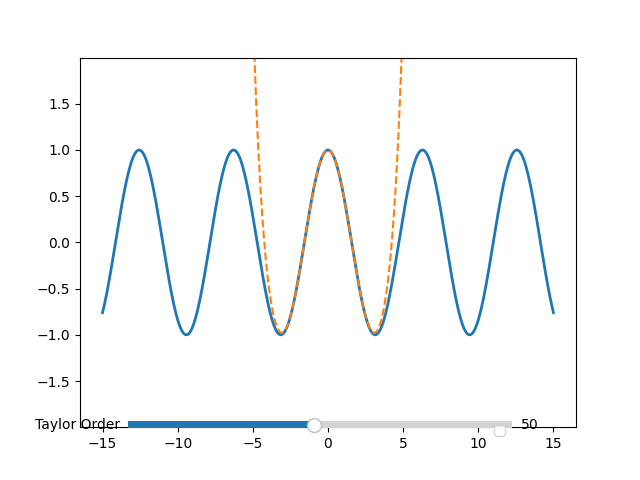

In [35]:
from matplotlib.widgets import Slider
from sympy.calculus.util import continuous_domain
%matplotlib widget


original_function = make_function(pe) #The Original
taylor_np = sp.lambdify(x, findTaylor(10), "numpy") #Taylor's Theorem

#domain = continuous_domain(taylor_np, x, S.Reals) #need to fingure out how to incorporate domain

#x and y values of the plotted lines
x_vals = np.linspace(-15, 15, 400)

y_np = original_function(x_vals)
y_sym = taylor_np(x_vals)

fig = plt.figure()
plt.plot(x_vals, y_np, label="Original", linewidth=2)
taylor_line, = plt.plot(x_vals, y_sym, label="Taylor Expansion", linestyle="--")


# y limits
padding = 0.5
y_min = np.nanmin(y_np)
y_max = np.nanmax(y_np)
yrange = y_max - y_min

plt.ylim(
    y_min - padding * yrange,
    y_max + padding * yrange
)

# --- slider ---
ax_slider = plt.axes([0.2, 0.1, 0.6, 0.03])
slider = Slider(
    ax=ax_slider,
    label="Taylor Order",
    valmin=3,
    valmax=100,
    valinit=50,
    valstep=1
)

def update_plot(val):
    taylor_np = sp.lambdify(x, findTaylor(int(val)), "numpy")
    taylor_line.set_ydata(taylor_np(x_vals))
    fig.canvas.draw_idle()

slider.on_changed(update_plot)


plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()
